In [9]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
df_m = pd.read_csv('../dataset/minority.csv')


In [3]:
df = pd.read_csv('../dataset/majority_informative.csv')

In [4]:
X_informative = df.drop(columns=['isFraud'])
Y_informative = df['isFraud'].values

In [5]:
df.columns

Index(['Unnamed: 0', 'type', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'isFraud'],
      dtype='object')

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_informative)  # required

.Kmeans, Majority class, Informative samples

In [7]:
X_informative.head()

,Unnamed: 0,type,oldbalanceOrg,newbalanceOrig,oldbalanceDest
0,2441017,0,28488.83,35434.00,955.51
1,2301877,0,5393405.29,5405360.93,280003.74
2,4605340,0,10579.00,21995.77,20104.93
3,2767579,0,39659.00,47338.39,54399.40
4,1559211,0,4922014.34,4931816.15,41993.56


In [8]:
X_informative.type.value_counts()

type
1    3772
3    3478
0     474
4     409
2      67
Name: count, dtype: int64

DBScan, Majority class, Informative samples

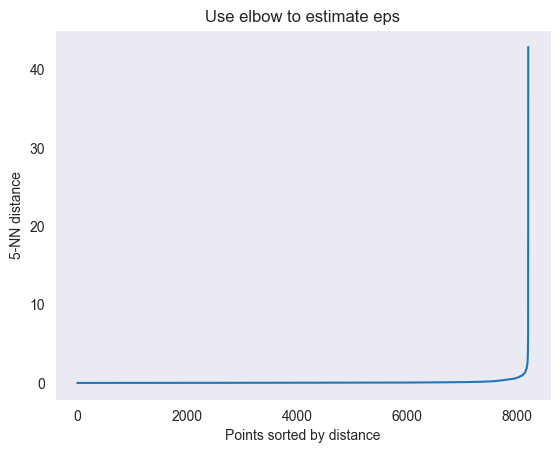

In [41]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Use min_samples = dimensionality or ~log(len(X))
min_samples = 5

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Plot sorted k-distances
k_distances = np.sort(distances[:, -1])
plt.plot(k_distances)
plt.ylabel(f"{min_samples}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("Use elbow to estimate eps")
plt.grid()
plt.show()


In [42]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

best_score = -1
best_params = {}

for eps in np.arange(0.2, 2.0, 0.1):
    for min_samples in range(4, 21):
        print(min_samples)
        print(eps)
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        print(f"Number of clusters: {n_clusters}")
        print(f"Number of noise points: {n_noise}")

        # Ignore if all points are noise or 1 cluster
        if len(set(labels)) <= 1 or (set(labels) == {-1}):
            continue

        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            print("Score: ", score)
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

print("Best parameters:", best_params)
print("Best silhouette score:", best_score)


4
0.2
Number of clusters: 18
Number of noise points: 551
Score:  -0.21218315182153896
5
0.2
Number of clusters: 14
Number of noise points: 586
Score:  -0.18662888640821937
6
0.2
Number of clusters: 10
Number of noise points: 628
Score:  -0.16854277556226235
7
0.2
Number of clusters: 9
Number of noise points: 647
Score:  -0.16340819667518433
8
0.2
Number of clusters: 7
Number of noise points: 679
Score:  -0.025456764427637214
9
0.2
Number of clusters: 8
Number of noise points: 690
10
0.2
Number of clusters: 8
Number of noise points: 734
Score:  0.027780066651198927
11
0.2
Number of clusters: 10
Number of noise points: 740
12
0.2
Number of clusters: 7
Number of noise points: 805
13
0.2
Number of clusters: 6
Number of noise points: 834
14
0.2
Number of clusters: 8
Number of noise points: 875
15
0.2
Number of clusters: 6
Number of noise points: 907
16
0.2
Number of clusters: 7
Number of noise points: 916
17
0.2
Number of clusters: 10
Number of noise points: 928
18
0.2
Number of clusters: 9

Silhouette Score = (b_i — a_i) / max(a_i, b_i)



In [43]:

db = DBSCAN(eps=0.5, min_samples=6)
labels = db.fit_predict(X_scaled)

# Exclude noise points (-1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
labels = db.labels_
score = silhouette_score(X_scaled, labels)

print(f"silhouette_score: {score}")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")



silhouette_score: 0.16449728535869576
Number of clusters: 12
Number of noise points: 260


##Tying for minor class


In [19]:
X_m = df_m.drop(columns=['isFraud'])
Y_m = df_m['isFraud'].values

In [20]:
scaler = StandardScaler()
X_mscaled = scaler.fit_transform(X_m)  # required

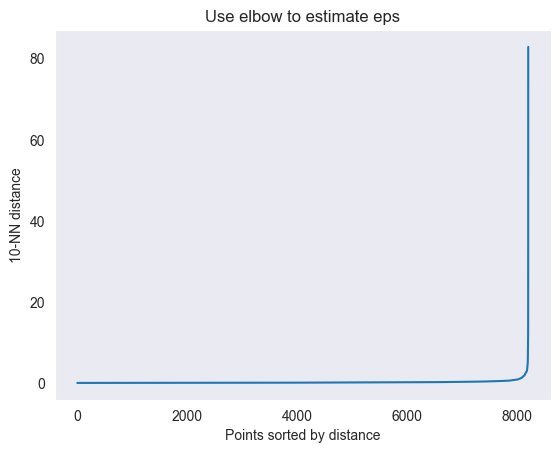

In [24]:

# Use min_samples = dimensionality or ~log(len(X))
min_samples = 10

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_mscaled)
distances, indices = neighbors_fit.kneighbors(X_mscaled)

# Plot sorted k-distances
k_distances = np.sort(distances[:, -1])
plt.plot(k_distances)
plt.ylabel(f"{min_samples}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("Use elbow to estimate eps")
plt.grid()
plt.show()


GMMs Clustering
BIC balances model fit and complexity — it penalizes models with more parameters to avoid overfitting.
In clustering (like Gaussian Mixture Models), lower BIC values indicate better models

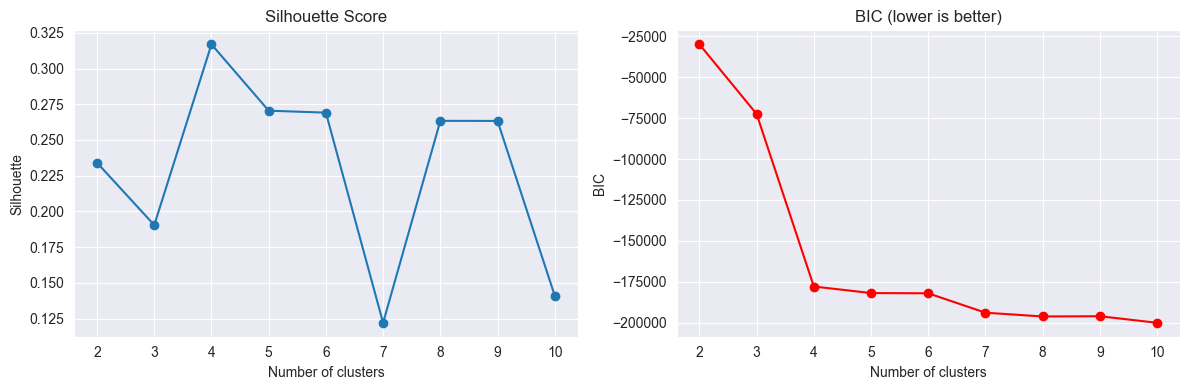

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Try different numbers of clusters (components)
n_components_range = range(2, 11)
sil_scores = []
bics = []

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    bic = gmm.bic(X_scaled)

    sil_scores.append(sil)
    bics.append(bic)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette")

plt.subplot(1, 2, 2)
plt.plot(n_components_range, bics, marker='o', color='red')
plt.title("BIC (lower is better)")
plt.xlabel("Number of clusters")
plt.ylabel("BIC")

plt.tight_layout()
plt.show()


In [12]:
best_k = n_components_range[sil_scores.index(max(sil_scores))]
print(f"Best number of clusters (k): {best_k}")


Best number of clusters (k): 4


In [14]:
gmm = GaussianMixture(n_components=best_k, random_state=42)
labels = gmm.fit_predict(X_scaled)
probs = gmm.predict_proba(X_scaled)  # optional: soft assignments


I:\ETVOS\2nd semester\DS Lab 1\DSLAB-Project\venv1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I:\ETVOS\2nd semester\DS Lab 1\DSLAB-Project\venv1\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
I:\ETVOS\2nd semester\DS Lab 1\DSLAB-Project\venv1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


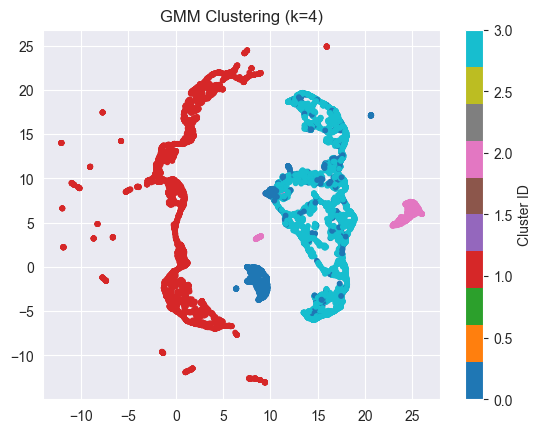

In [21]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"GMM Clustering (k={best_k})")
plt.colorbar(label="Cluster ID")
plt.show()


In [26]:
X_df = pd.DataFrame(X_scaled, columns=X_informative.columns)

# Add cluster labels and the target (is_fraud = 0 for majority class)
X_df['cluster'] = labels
X_df['is_fraud'] = Y_informative  # 0s for majority class

In [27]:


for cluster_id in sorted(X_df['cluster'].unique()):
    cluster_df = X_df[X_df['cluster'] == cluster_id]
    cluster_df.to_csv(f"../dataset/informative_cluster_{cluster_id}.csv", index=False)


For minority data

In [30]:
X_min = df_m.drop(columns=['isFraud'])
Y_min = df_m['isFraud'].values
X_min_scaled = scaler.fit_transform(X_min)

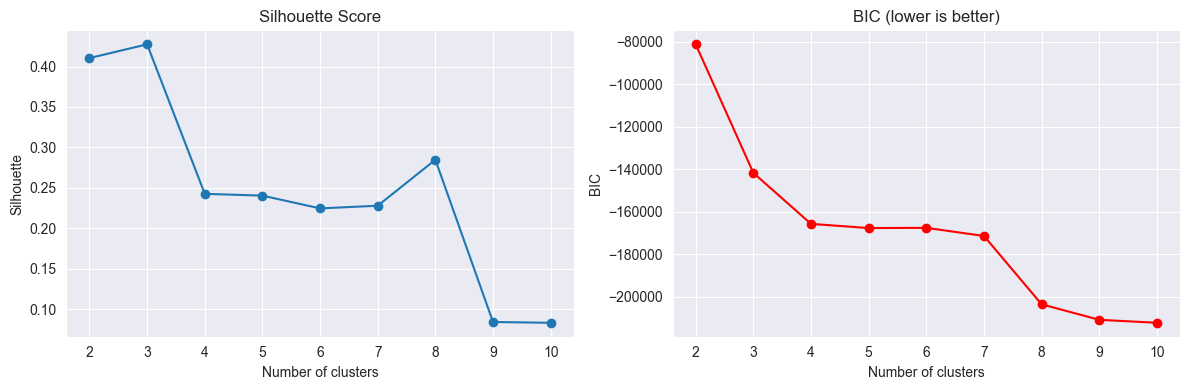

In [31]:


# Try different numbers of clusters (components)
n_components_range = range(2, 11)
sil_scores = []
bics = []

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_min_scaled)

    sil = silhouette_score(X_min_scaled, labels)
    bic = gmm.bic(X_min_scaled)

    sil_scores.append(sil)
    bics.append(bic)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette")

plt.subplot(1, 2, 2)
plt.plot(n_components_range, bics, marker='o', color='red')
plt.title("BIC (lower is better)")
plt.xlabel("Number of clusters")
plt.ylabel("BIC")

plt.tight_layout()
plt.show()


In [32]:
best_k = n_components_range[sil_scores.index(max(sil_scores))]
print(f"Best number of clusters (k): {best_k}")


Best number of clusters (k): 3


In [33]:
gmm = GaussianMixture(n_components=best_k, random_state=42)
labels = gmm.fit_predict(X_min_scaled)
probs = gmm.predict_proba(X_min_scaled)  # optional: soft assignments


I:\ETVOS\2nd semester\DS Lab 1\DSLAB-Project\venv1\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
I:\ETVOS\2nd semester\DS Lab 1\DSLAB-Project\venv1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


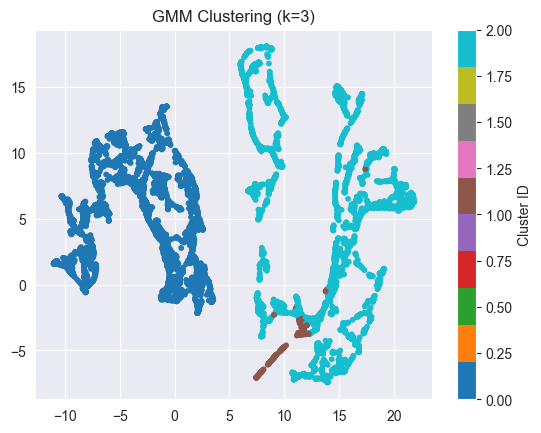

In [34]:

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_min_scaled)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"GMM Clustering (k={best_k})")
plt.colorbar(label="Cluster ID")
plt.show()


In [36]:
X_df = pd.DataFrame(X_min_scaled, columns=X_min.columns)

# Add cluster labels and the target (is_fraud = 0 for majority class)
X_df['cluster'] = labels
X_df['is_fraud'] = Y_min  # 0s for majority class

In [37]:
for cluster_id in sorted(X_df['cluster'].unique()):
    cluster_df = X_df[X_df['cluster'] == cluster_id]
    cluster_df.to_csv(f"../dataset/minority_cluster_{cluster_id}.csv", index=False)
